**Data Process Stages**
1. Creating Dataset
2. Cleaning Datas
3. Visualizing Cleaned Datas
4. Split Dataset
5. Create a CNN Model
6. Train Model
7. Evaluate Model Performance

## Installing Dependencies

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import DataLoader

## Creating Custom Dataset

In [2]:
#Creating Customize Dataset
class FoodsDataset(Dataset):
    def __init__(self, root_dir, transforms=None, train=True):
        self.root_dir = root_dir
        self.transforms = transforms
        self.train = train
        self.data_list = []
        self.label_list = []
        self.categories = sorted(os.listdir(root_dir))
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.categories)

        # Converting, Resizing, Encoding and Assembling Image Datas, and Labels
        for category in self.categories:
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                for image_name in os.listdir(category_path):
                    image_path = os.path.join(category_path, image_name)
                    img = Image.open(image_path).convert('RGB')
                    img = img.resize((224, 224)) 
                    self.data_list.append(img)
                    self.label_list.append(category)
        
        self.label_list = np.array(self.label_encoder.transform(self.label_list))
        
    def __len__(self):
        # Length of Dataset
        return len(self.data_list)
     
    def __getitem__(self, idx):
        #Return Image and Labels by Index
        img = self.data_list[idx]
        label = self.label_list[idx]
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

#Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),    
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Normalization
test_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

#Calling Class
train_dataset = FoodsDataset(root_dir="/kaggle/input/food11/food11/train/", transforms=train_transforms, train=True)
test_dataset = FoodsDataset(root_dir="/kaggle/input/food11/food11/test/", transforms=test_transforms, train=False)

#Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Visualizing Shuffled Dataset

In [3]:
#Labelling
test_dir = "/kaggle/input/food11/food11/test/"
categories = sorted(os.listdir(test_dir))
labels = {} 
one_hot_labels = {} 
lnth = len(categories)
eyes = np.eye(lnth)

# Creating Hash Map to Visualize Matched Image Data and Labels
for i, category in enumerate(categories):
    labels[i] = category  
    one_hot_labels[i] = eyes[i] 

# Sonuçları yazdıralım
print("Labels Dictionary (Kategori No ve Adı):")
print(labels)

print("\nOne-Hot Encoding Labels Dictionary:")
print(one_hot_labels)


Labels Dictionary (Kategori No ve Adı):
{0: 'apple_pie', 1: 'cheesecake', 2: 'chicken_curry', 3: 'french_fries', 4: 'fried_rice', 5: 'hamburger', 6: 'hot_dog', 7: 'ice_cream', 8: 'omelette', 9: 'pizza', 10: 'sushi'}

One-Hot Encoding Labels Dictionary:
{0: array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 2: array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 3: array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 4: array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]), 5: array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), 6: array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), 7: array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 8: array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 9: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 10: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}


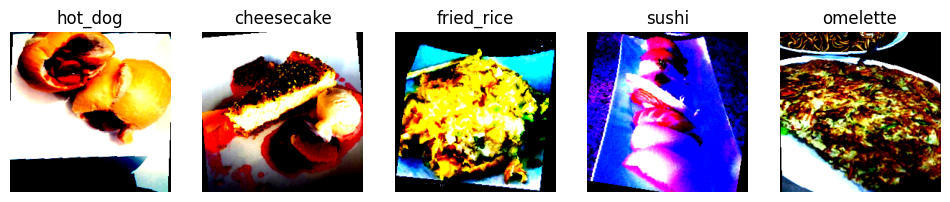

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Leaving Size for Visualization
img, label = next(iter(train_loader))
fig, axes = plt.subplots(1, 5, figsize=(12, 5))

# Visualize Image and Labels Per Index
for i in range(5):
    image = img[i].numpy().transpose((1, 2, 0)) 
    image = np.clip(image, 0, 1)  # Görüntüyü 
    image = Image.fromarray((image * 255).astype(np.uint8))  
    axes[i].imshow(image)
    label_idx = label[i].argmax().item() if len(label[i].shape) > 1 else int(label[i].item())
    axes[i].set_title(labels[label_idx])
    
    # Eksenleri kapatma
    axes[i].axis("off")

plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class VGG16TransferLearning(nn.Module):
    def __init__(self, num_classes=11):
        #Inherit init method of parent class
        super(VGG16TransferLearning, self).__init__()

        #VGG16 Transfer Learning Model
        vgg16 = models.vgg16(weights = True)
        
        self.features = vgg16.features
        
        #Sequential Fully Connected Layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(25088, 4096),  
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)  
        )
        
        for param in self.features.parameters():
            param.requires_grad = False  
        
        for param in self.classifier.parameters():
            param.requires_grad = True

    #Forward Pass
    def forward(self, x):
        x = self.features(x)
        
        x = torch.flatten(x, 1) 
        
        x = self.classifier(x)
        
        return x

model = VGG16TransferLearning(num_classes=11)  # Sınıf sayınızı buraya girin

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 200MB/s]


VGG16TransferLearning(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pad

## Training and Evaluating Datas

In [6]:
# Training function with Early Stopping and Learning Rate Decay
def train_model_with_early_stopping_and_lr_decay(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100, patience=5):
    model.to(device)
    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        # Training loop
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

            if i % 200 == 199:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {running_loss / 200:.4f}")
                running_loss = 0.0

        # Training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds
        print(f"Epoch {epoch+1} - Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy*100:.2f}%")

        # Validation and Early Stopping Check
        val_loss, val_accuracy, val_f1 = evaluate_model(model, val_loader, criterion, device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"Validation Loss improved to {val_loss:.4f}. Saving the model!")
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping after {patience} epochs without improvement!")
            break

        # Learning Rate Decay
        scheduler.step()  # Step the learning rate scheduler

# Test function
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()  
    all_preds = []
    all_labels = []
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_preds / total_preds
    f1 = f1_score(all_labels, all_preds, average='weighted')  # weighted F1
    test_loss /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    print(f"Test F1 Score: {f1:.4f}")
    return test_loss, accuracy, f1


# Example of usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have a VGG16 model and DataLoader objects (train_loader and val_loader)
model = VGG16TransferLearning()  # replace with your actual model
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Learning Rate Decay: Reduce learning rate by factor of 0.1 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 10
train_model_with_early_stopping_and_lr_decay(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=num_epochs, patience=5)


Epoch [1/10], Step [200], Loss: 1.6683
Epoch 1 - Training Loss: 0.4136, Training Accuracy: 58.09%
Test Loss: 0.8575
Test Accuracy: 77.36%
Test F1 Score: 0.7741
Validation Loss improved to 0.8575. Saving the model!
Epoch [2/10], Step [200], Loss: 1.0094
Epoch 2 - Training Loss: 0.3590, Training Accuracy: 69.08%
Test Loss: 0.7623
Test Accuracy: 77.64%
Test F1 Score: 0.7735
Validation Loss improved to 0.7623. Saving the model!
Epoch [3/10], Step [200], Loss: 0.9542
Epoch 3 - Training Loss: 0.3311, Training Accuracy: 71.15%
Test Loss: 0.8332
Test Accuracy: 76.27%
Test F1 Score: 0.7592
Epoch [4/10], Step [200], Loss: 0.8640
Epoch 4 - Training Loss: 0.3274, Training Accuracy: 73.49%
Test Loss: 0.8590
Test Accuracy: 75.82%
Test F1 Score: 0.7554
Epoch [5/10], Step [200], Loss: 0.8451
Epoch 5 - Training Loss: 0.2926, Training Accuracy: 74.64%
Test Loss: 0.7663
Test Accuracy: 78.09%
Test F1 Score: 0.7811
Epoch [6/10], Step [200], Loss: 0.7864
Epoch 6 - Training Loss: 0.2849, Training Accuracy: 7